**Problem Statement**

Predict the orientation of whales using annotated whale image set. The annotations contain bounding box coordinates and angle in radians as theta.  

The give dataset is in test,train, validation sets with annotations

Following are preformed for analysis and solution 


*   EDA  - The images from train set are visualized with bounding box . Basic EDA is performed on dataset to understand the dataset. 

* Preprocessing - The train, test and validation sets data, image location, annotation details needed for model is saved as a dataframe, that is further used by the model dataset. The orientation angle is converted to degrees and used as prediction output and fares better with regression loss. 

*   Model and Dataset - For each item of dataset, the image is read from the filename with prefix and resize, normalize transform is applied to suit the resnet model input. 
Pretrained Resnet34 model is used as a base and FC layer is added for theta output. Mean of abosolute values of prediction and atual theta values are used for regression loss. 
* Training - The model is trained for 60 epochs. However training for more number of epochs could yield better results. 

* Test Results - The test set is used for predictions on the traine model and the results are shown as a dataframe and saved as a csv file

* Experiments - MSE loss, L1 Loss and absolute mean loss are tried and absolute mean loss seems to have better performance

* Further Enhancements - Model can be tried for larger number of epcohs on CUDA instance. The current model is trained on Google colab for 60 epochs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/wm'

/content/drive/MyDrive/wm


**Datasets** : get the datasets and save in the drive

In [ ]:

#!wget https://cthulhu.dyn.wildme.io/public/data/orientation_test_whaleshark.zip
#!unzip orientation_test_whaleshark.zip
#!wget https://cthulhu.dyn.wildme.io/public/data/orientation_test_spotted_dolphin.zip
#!unzip orientation_test_spotted_dolphin.zip

In [ ]:
import json
import numpy as np
from operator import itemgetter
import pandas as pd

import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np
import albumentations as A
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
%reload_ext autoreload
%autoreload 2
%matplotlib inline


**Preprocessing** 

Read the annotations from json file to a dataframe. Create a thetadeg column that holds the orientation angle in degrees

In [ ]:

def get_key_from_value(img_id_list, val):
    
    k = np.where(img_id_list==val)
    idx = k[0][0]
    return idx
    

def get_annot_df(jsonfile)  :

  with open(jsonfile) as json_file:
    data = json.load(json_file)
 
    # Print the type of data variable
    images = data['images']
    annotations = data['annotations']

    image_id_list = np.asarray(list(map(itemgetter('id'), images)))
    #print(image_id_list[:10])
    image_file_list = list(map(itemgetter('file_name'), images))
    image_ht_list = list(map(itemgetter('height'), images))
    image_wd_list = list(map(itemgetter('width'), images))
    anno_list=[]
    for annot in annotations:
      a_img_id = annot['image_id']
      idx = get_key_from_value(image_id_list,  a_img_id)
    
      img_f, img_wd, img_ht = image_file_list[idx], image_wd_list[idx], image_ht_list[idx]
      anno = {}
      anno['img_id'] = a_img_id
  
      anno['file_name'] =img_f
      anno['width'] =img_wd
      anno['height'] =img_ht
      anno['bbox'] = annot['bbox']
      anno['theta'] = annot['theta']
      anno['thetadeg'] = math.degrees( anno['theta'] )
      anno['class']  = annot['category_id']
      anno_list.append(anno)
  return pd.DataFrame(anno_list)


Obtain train, test , validation features into respective dataframes 

In [ ]:
tr_jsonfile = 'orwhalesharkcoco/annotations/instances_train2020.json'
train_df = get_annot_df(tr_jsonfile)


In [ ]:
train_df.head()

,img_id,file_name,width,height,bbox,theta,thetadeg,class
0,1,000000000001.jpg,2400,1800,"[0, 389, 1978, 1022]",-0.103981,-5.957673,0
1,3,000000000003.jpg,2400,1532,"[0, 113, 2399, 1418]",0.038014,2.178029,0
2,4,000000000004.jpg,2400,1113,"[0, 0, 2399, 1112]",0.183952,10.539681,0
3,6,000000000006.jpg,2400,1836,"[0, 44, 2399, 1618]",-0.133618,-7.655755,0
4,8,000000000008.jpg,2400,1920,"[0, 233, 2399, 1686]",0.080697,4.623606,0


In [ ]:
ts_jsonfile = 'orwhalesharkcoco/annotations/instances_test2020.json'
test_df = get_annot_df(ts_jsonfile)



In [ ]:
val_jsonfile = 'orwhalesharkcoco/annotations/instances_val2020.json'
val_df = get_annot_df(val_jsonfile)


In [ ]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)



In [ ]:
#Function to visualize the annotations
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    print(bbox, len(bbox))
    [x_min, y_min, w, h] = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bbox):
    img = image.copy()
    img = visualize_bbox(img, bbox, 'shark')
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(img)

orwhalesharkcoco/images/train2020/000000000001.jpg 2400 1800 [0, 389, 1978, 1022]
[0, 389, 1978, 1022] 4


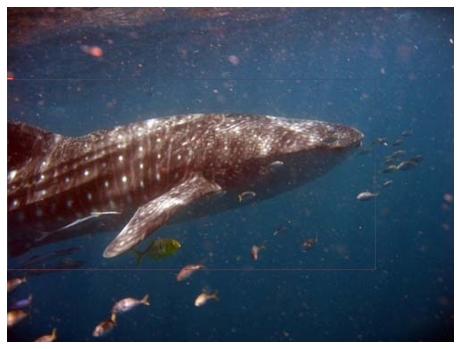

In [ ]:
#Visualize a sample train image with bounding box annotation
PFX = 'orwhalesharkcoco/images/train2020/'
idx=0

file = PFX+train_df['file_name'][idx]
wd = train_df['width'][idx]
ht = train_df['height'][idx]
bbox =train_df['bbox'][idx]
print(file, wd, ht, bbox)
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image, bbox)

In [ ]:
bboxes= [bbox]
bboxes


[[0, 389, 1978, 1022]]

In [ ]:
# Apply resize transform to image (224x224) and see the bounding box params
labels = ['shark']
rsztransform = A.Compose(
    [A.Resize(224,224, p=1)],
    bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
   )

idx=1
PFX = 'orwhalesharkcoco/images/train2020/'
file = PFX+train_df['file_name'][idx]
wd = train_df['width'][idx]
ht = train_df['height'][idx]
bbox =train_df['bbox'][idx]
print(file, wd, ht, bbox)
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape, bbox, labels)
transformed = rsztransform(image=image, bboxes=[bbox], labels=labels)
f = transformed['image']


tbox = transformed['bboxes'][0]

print(f.shape, transformed['bboxes'][0])

orwhalesharkcoco/images/train2020/000000000003.jpg 2400 1532 [0, 113, 2399, 1418]
(1532, 2400, 3) [0, 113, 2399, 1418] ['shark']
(224, 224, 3) (0.0, 16.52219321148825, 223.90666666666667, 207.33159268929504)


SharkDataset Class with transform using the dataframe with transform and normalize function

In [ ]:


def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]
class SharkDataset(Dataset):
    def __init__(self, pfx, paths, bb, y, theta):
        self.pfx = pfx
        self.paths = paths.values
        self.bb = bb.values
        self.theta = theta.values
        self.y = y.values
        self.category_ids = [0]
        self.transforms = A.Compose(
                          [A.Resize(224,224, p=1)],
                          bbox_params=A.BboxParams(format='coco', label_fields=['category_ids'])
)
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.pfx+self.paths[idx]
        y_class = self.y[idx]
        y_bb=self.bb[idx]
        x = cv2.imread(str(path)).astype(np.float32)
        image = cv2.cvtColor(x,  cv2.COLOR_BGR2RGB)/255
        
        tr_x = self.transforms(image=image, bboxes=[y_bb], category_ids=self.category_ids)
        x = tr_x['image']
        
        x = normalize(x)
        x = np.rollaxis(x, 2)
        #y_bb = tr_x['bboxes'][0] 
        y_theta = self.theta[idx].astype('float')
        
        
        return x, y_class, y_bb, y_theta

In [ ]:
TR_PFX= 'orwhalesharkcoco/images/train2020/'
X_train = train_df
#train_ds = SharkDataset(TR_PFX, X_train['file_name'],X_train['bbox'] ,X_train['class'],X_train['theta'] )
train_ds = SharkDataset(TR_PFX, X_train['file_name'],X_train['bbox'] ,X_train['class'],X_train['thetadeg'] )

In [ ]:
VAL_PFX= 'orwhalesharkcoco/images/val2020/'
X_val = val_df
valid_ds = SharkDataset(VAL_PFX, X_val['file_name'],X_val['bbox'] ,X_val['class'],X_val['thetadeg'] )


In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=10)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,num_workers=4)

Define model with Resnet34 pretrained model, add FC layer for orientation output 

In [ ]:
class SharkO_model(nn.Module):
    def __init__(self):
        super(SharkO_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.theta = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 1))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        #return self.theta(x), self.bb(x)
        return self.theta(x)

In [ ]:
##Training 

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [ ]:
#Training loop function
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb, y_theta in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            
            y_bb = torch.cat(y_bb, dim=0)
            y_bb = y_bb.cuda()
            y_theta = y_theta.type(torch.FloatTensor) \
                  .reshape((y_theta.shape[0], 1))
            y_theta = y_theta.cuda()
            out_theta = model(x)
            #loss_theta = F.l1_loss(out_theta, y_theta, reduction="none")
            #loss_theta = F.mse_loss(out_theta,y_theta)
            loss=torch.abs(out_theta - y_theta).mean() 
            #loss = loss_theta.sum()
            model.zero_grad()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f " % (train_loss, val_loss))
    return sum_loss/total

In [ ]:
#Validation metrics
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb, y_theta in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = torch.cat(y_bb, dim=0)
    
        y_theta = y_theta.type(torch.FloatTensor) \
                  .reshape((y_theta.shape[0], 1))
        y_theta = y_theta.cuda()
        out_theta= model(x)
        #loss_theta = F.l1_loss(out_theta, y_theta, reduction="none")
        #loss_theta = F.mse_loss(out_theta,y_theta)
        #loss_theta = loss_theta.sum()
        #loss_theta=torch.abs(out_theta - y_theta).log()
        loss_theta=torch.abs(out_theta - y_theta).mean()             
        loss = loss_theta
        sum_loss += loss.item()
        total += batch
    return sum_loss/total

In [ ]:
model = SharkO_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=1e-3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

In [ ]:

torch.save(model.state_dict(), 'shark_obb.pth')

In [ ]:
#Train for more epochs
update_optimizer(optimizer, 1e-4)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=30)

train_loss 0.246 val_loss 0.248 
train_loss 0.236 val_loss 0.254 
train_loss 0.229 val_loss 0.251 
train_loss 0.226 val_loss 0.249 
train_loss 0.217 val_loss 0.251 
train_loss 0.215 val_loss 0.251 
train_loss 0.212 val_loss 0.251 
train_loss 0.219 val_loss 0.253 
train_loss 0.208 val_loss 0.255 
train_loss 0.217 val_loss 0.257 
train_loss 0.205 val_loss 0.255 
train_loss 0.204 val_loss 0.255 
train_loss 0.204 val_loss 0.253 
train_loss 0.204 val_loss 0.255 
train_loss 0.198 val_loss 0.258 
train_loss 0.199 val_loss 0.255 
train_loss 0.220 val_loss 0.257 
train_loss 0.196 val_loss 0.255 
train_loss 0.213 val_loss 0.253 
train_loss 0.218 val_loss 0.256 
train_loss 0.216 val_loss 0.255 
train_loss 0.199 val_loss 0.255 
train_loss 0.201 val_loss 0.260 
train_loss 0.194 val_loss 0.260 
train_loss 0.206 val_loss 0.259 
train_loss 0.199 val_loss 0.257 
train_loss 0.189 val_loss 0.262 
train_loss 0.187 val_loss 0.260 
train_loss 0.192 val_loss 0.254 
train_loss 0.193 val_loss 0.257 


0.19319527365944603

In [ ]:
torch.save(model.state_dict(), 'shark_obb1.pth')

**Test Set Predictions and Model evaluation**

In [ ]:
TEST_PFX= 'orwhalesharkcoco/images/test2020/'
X_val = test_df
test_ds = SharkDataset(TEST_PFX, X_val['file_name'],X_val['bbox'] ,X_val['class'],X_val['thetadeg'] )
test_dl = DataLoader(test_ds, batch_size=batch_size,num_workers=4)

In [ ]:

model.eval()
pred=[]
for x, y_class, y_bb, y_theta in test_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        
        y_theta = y_theta.type(torch.FloatTensor) \
                  .reshape((y_theta.shape[0], 1))
        y_theta = y_theta.cuda()
        out_theta= model(x)
        pred_thetas = out_theta.detach().cpu().numpy() 
        for elem in pred_thetas:
            pred.append(elem)
        

In [ ]:
len(pred)
preds = np.concatenate( pred, axis=0 )

In [ ]:

test_df['preds']= preds

In [ ]:
test_df.head(10)

,img_id,file_name,width,height,bbox,theta,thetadeg,class,preds
0,5,000000000005.jpg,2400,1801,"[508, 187, 1891, 1613]",0.041628,2.385116,0,14.102492
1,10,000000000010.jpg,2400,1800,"[50, 7, 2349, 1525]",0.167852,9.617231,0,10.725406
2,31,000000000031.jpg,2400,1444,"[0, 30, 1625, 1317]",-0.371192,-21.267747,0,-18.053425
3,32,000000000032.jpg,2400,1800,"[0, 382, 1890, 1223]",0.200859,11.508370,0,9.430607
4,40,000000000040.jpg,2400,1906,"[0, 157, 2399, 1748]",-0.066810,-3.827959,0,-6.153460
5,44,000000000044.jpg,2400,1350,"[0, 56, 1989, 1110]",-0.169188,-9.693751,0,-6.855433
6,45,000000000045.jpg,2400,1920,"[0, 440, 1823, 1479]",-0.400707,-22.958842,0,-13.704101
7,47,000000000047.jpg,2400,1920,"[0, 593, 2047, 1117]",0.137179,7.859791,0,6.355702
8,52,000000000052.jpg,2400,1800,"[270, 328, 2027, 867]",0.046149,2.644115,0,5.676811
9,54,000000000054.jpg,2400,1443,"[20, 293, 2379, 1149]",0.054933,3.147438,0,5.881544


In [ ]:
#save predictions
test_df.to_csv('pred1.csv', index=False)

**Observations**

The spotted whale shark dataset model is based on pretrained Resnet34 model and modified with FC layer for theta predictions. 

*   Theta angle in degrees is used for this dataset as predicted feature. 
*  Mean absolute loss is used and seemed to fare better compared to MSE loss.
*   Model is trained on Google Colab for fewer epochs. 
*   Model can be further enhanced on GPU with higher RAM VM instance 








